In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")
 
learning_rate = 0.001
batch = 4
epochs = 20

cuda is available


In [78]:
import cv2
import numpy as np
import os
from PIL import Image
from collections import Counter

good_dir = os.listdir('./train_set/good')
bad_dir = os.listdir('./train_set/bad')
train_set = []
target_set = []
for dir in good_dir:
    train_set.append(Image.open('./train_set/good/'+dir).resize((512,512)))
    target_set.append([False])
for dir in bad_dir:
    train_set.append(Image.open('./train_set/bad/'+dir).resize((512,512)))
    target_set.append([True])

In [79]:
x = train_set
y = target_set

In [80]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True)
x_train, x_valid, y_train,  y_valid = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, shuffle=True )

In [81]:
from typing import Any


class Normalization(object):
  def __init__(self, mean=0.5 , std=0.5):
    self.mean = mean
    self.std = std
  
  def __call__(self, data):

    data =(data - self.mean) / self.std

    return data

class image2np(object):
  def __init__(self, label):
    self.label = label

  def __call__(self, img):
    img = np.array(img, dtype=np.float32)
    if img.ndim == 2:
      img = img[:, :, np.newaxis]
    if self.label:
      img = np.where(img == 0, 1, 255)
    return img/255

In [82]:
import albumentations as a

def image_preprocess(img_arr, target_arr, train = True):
    blur = a.OneOf([
                a.MotionBlur(p=1),
                a.OpticalDistortion(p=1)           
    ], p=1)
    x_res = []
    y_res = []
    x_compose = [
        Normalization(mean= 0.5, std =0.5),
        transforms.ToTensor()
    ]
    y_compose = [
        transforms.ToTensor()
    ]
    
    tf1 = transforms.Compose(x_compose)
    tf2 = transforms.Compose(y_compose)

    if train:
        for new_img,target in zip(image2np(label=False)(img_arr),target_arr):
            res = a.VerticalFlip(p=1)(image = new_img)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(target)

            res = a.HorizontalFlip(p=1)(image = new_img)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(target)

            res = a.Affine(p=1)(image = new_img)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(target)

            res = a.RandomRotate90(p=1)(image = new_img)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(target)

            res = a.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)(image = new_img)
            x_res.append(tf1(blur(image = res['image'])['image']))
            y_res.append(target)

            x_res.append(tf1(new_img))
            y_res.append(target)
    else:
        for new_img,target in zip(image2np(label=False)(img_arr),target_arr):            
            x_res.append(tf1(new_img))
            y_res.append(target)
    
    return x_res, y_res

In [83]:
# 이미지 전처리 적용
x_train, y_train = image_preprocess(x_train, y_train)
x_valid, y_valid = image_preprocess(x_valid, y_valid, train=False)
x_test, y_test = image_preprocess(x_test, y_test, train=False)

In [84]:
np.array(x_train).shape, np.array(x_valid).shape,np.array(x_test).shape

((492, 3, 512, 512), (28, 3, 512, 512), (28, 3, 512, 512))

In [85]:
from torch.utils.data import TensorDataset, DataLoader

traindata = TensorDataset(torch.stack(x_train),torch.tensor(y_train))
validdata = TensorDataset(torch.stack(x_valid),torch.tensor(y_valid))
testdata = TensorDataset(torch.stack(x_test),torch.tensor(y_test))

trainLoader = DataLoader(
    traindata,
    batch_size=batch,
    shuffle = True
)
validLoader = DataLoader(
    validdata,
    batch_size=batch,
    shuffle = True
)
testLoader = DataLoader(
    testdata,
    batch_size=1,
    shuffle = True
)


torch.Size([3, 512, 512]) torch.Size([1])
[-1.         -0.9980392  -0.99791664 ...  0.9999387   0.99994636
  1.        ]


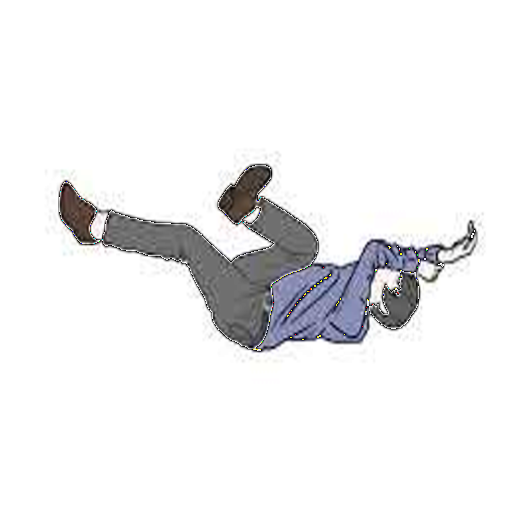

In [86]:
test = iter(traindata)
a,b = next(test)
print(a.shape,b.shape)
print(np.unique(a))
transforms.ToPILImage()(a)

In [88]:
model = torchvision.models.resnet50(pretrained=True)
model

c:\Users\dkstn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dkstn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [89]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

In [90]:
from torchsummary import summary
model.cuda()
summary(model, input_size=(3,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [91]:
import time 
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = 100*train_correct/len(train_loader.dataset)
        valid_acc = 100*valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
        torch.save(model, f'./model{epoch}.pt')
    
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

9.753sec : [Epoch 1/10] -> train loss: 0.5115, train acc: 74.390% / valid loss: 0.3960, valid acc: 78.571%
9.691sec : [Epoch 2/10] -> train loss: 0.3087, train acc: 86.992% / valid loss: 0.2613, valid acc: 89.286%
9.717sec : [Epoch 3/10] -> train loss: 0.2039, train acc: 94.512% / valid loss: 0.2230, valid acc: 96.429%
9.451sec : [Epoch 4/10] -> train loss: 0.1060, train acc: 97.561% / valid loss: 0.1811, valid acc: 96.429%
9.182sec : [Epoch 5/10] -> train loss: 0.0539, train acc: 99.187% / valid loss: 0.1881, valid acc: 96.429%
9.078sec : [Epoch 6/10] -> train loss: 0.0787, train acc: 98.577% / valid loss: 0.1029, valid acc: 100.000%
9.018sec : [Epoch 7/10] -> train loss: 0.1054, train acc: 98.171% / valid loss: 0.2120, valid acc: 92.857%
9.151sec : [Epoch 8/10] -> train loss: 0.0353, train acc: 99.187% / valid loss: 0.1407, valid acc: 92.857%
9.063sec : [Epoch 9/10] -> train loss: 0.0748, train acc: 98.577% / valid loss: 0.1325, valid acc: 96.429%
9.031sec : [Epoch 10/10] -> train lo

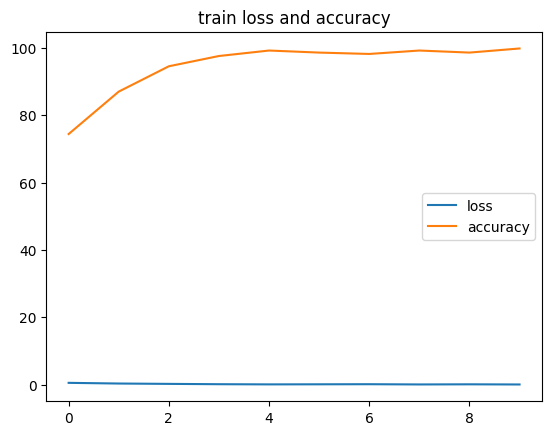

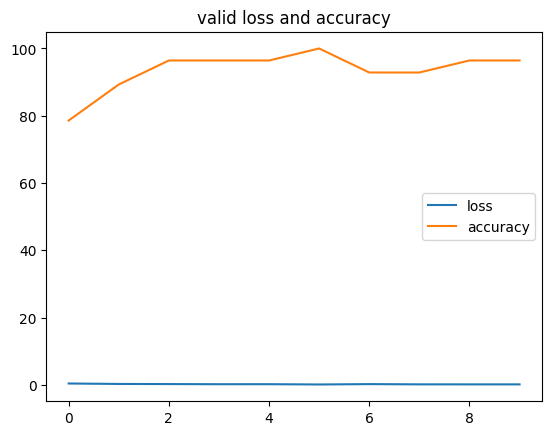

In [92]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
 
fit(model, criterion, optimizer, 10, trainLoader, validLoader)


In [93]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            print(pred)
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')


In [95]:
eval(model, criterion, testLoader)

tensor([[9.7402e-05]], device='cuda:0')
tensor([[4.4751e-06]], device='cuda:0')
tensor([[0.0002]], device='cuda:0')
tensor([[7.9969e-06]], device='cuda:0')
tensor([[0.0002]], device='cuda:0')
tensor([[0.3731]], device='cuda:0')
tensor([[0.9831]], device='cuda:0')
tensor([[0.3338]], device='cuda:0')
tensor([[0.0001]], device='cuda:0')
tensor([[0.9944]], device='cuda:0')
tensor([[0.0047]], device='cuda:0')
tensor([[0.0648]], device='cuda:0')
tensor([[0.7962]], device='cuda:0')
tensor([[0.4621]], device='cuda:0')
tensor([[0.0454]], device='cuda:0')
tensor([[0.9986]], device='cuda:0')
tensor([[0.0002]], device='cuda:0')
tensor([[0.8095]], device='cuda:0')
tensor([[0.0060]], device='cuda:0')
tensor([[0.9479]], device='cuda:0')
tensor([[0.0002]], device='cuda:0')
tensor([[0.0847]], device='cuda:0')
tensor([[0.6985]], device='cuda:0')
tensor([[0.0002]], device='cuda:0')
tensor([[0.0300]], device='cuda:0')
tensor([[0.1651]], device='cuda:0')
tensor([[5.4715e-07]], device='cuda:0')
tensor([[0.0